# Song release year prediction

Prediction of the release year of a song from audio features. Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s. Dataset downloaded from http://archive.ics.uci.edu/ml/machine-learning-databases/00203/

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.base import clone
%matplotlib inline

# Loading data and train/test splitting
Loading the dataset and perform train test splitting required by the UCI dataset page. "You should respect the following train / test split: \
train: first 463,715 examples \
test: last 51,630 examples \
It avoids the 'producer effect' by making sure no song \
from a given artist ends up in both the train and test set."

In [4]:
data = np.genfromtxt('./YearPredictionMSD.txt', delimiter=',')

In [5]:
X_train, y_train, X_test, y_test = data[:463715, 1:], data[:463715, 0], data[463715:, 1:], data[463715:, 0]

# Data exploration

**1. Check the distribution of release years in both train and test datasets.**

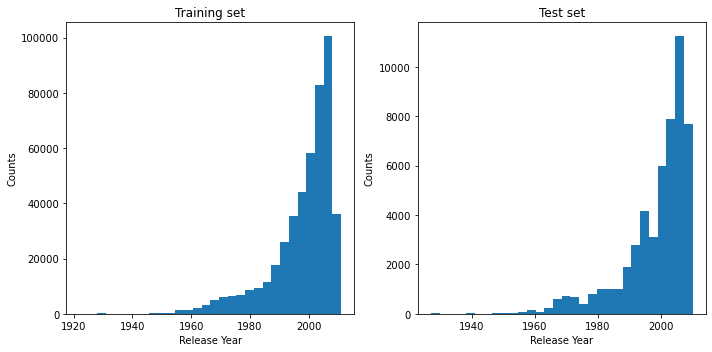

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(y_train, bins=30)
plt.xlabel('Release Year')
plt.ylabel('Counts')
plt.title('Training set')

plt.subplot(1,2,2)
plt.hist(y_test, bins=30)
plt.xlabel('Release Year')
plt.ylabel('Counts')
plt.title('Test set')
plt.tight_layout()

As shown above, the distribution of the release years for the training set and the test set are similar. Most of the songs are in the 2000s.

**2. Check the top 20 features selected by the univariate f_regression.**

In [16]:
skb = SelectKBest(f_regression, k=20)
skb.fit(X_train, y_train)
col_names = np.array([f'mean_{i+1}' for i in range(12)] + [f'cov_{i+1}' for i in range(78)])
selected_idx = skb.get_support()
selected_names = col_names[selected_idx]
X_train_reduced = X_train[:, selected_idx]
X_test_reduced = X_test[:, selected_idx]
X_train_corr = [np.corrcoef(X_train_reduced[:, i], y_train)[0][1] for i in range(20)]
X_test_corr = [np.corrcoef(X_test_reduced[:, i], y_test)[0][1] for i in range(20)]

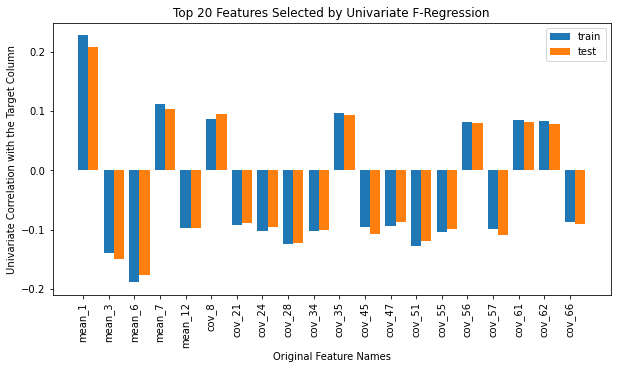

In [28]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(20), X_train_corr, width=0.4, label='train')
plt.bar(np.arange(20)+0.4, X_test_corr, width=0.4, label='test')
plt.xticks(np.arange(20), selected_names, rotation=90)
plt.xlabel('Original Feature Names')
plt.ylabel('Univariate Correlation with the Target Column')
plt.title('Top 20 Features Selected by Univariate F-Regression')
plt.legend()
plt.show()

The figure above shows the correlation between the top 20 features selected by the f_regression and the target column (release year). The selection is done for the training set only and it applies to the test set pretty well.

# Define a Model class 
Define a Model class to perform similar train/evaluate steps for different algorithms.

In [45]:
class Model(object):
    def __init__(self, scikit_model, X_train, y_train, X_test, y_test, X_train_reduced, X_test_reduced):
        self.model = clone(scikit_model)
        self.model_reduced = clone(scikit_model)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_reduced = X_train_reduced
        self.X_test_reduced = X_test_reduced
    
    def train(self):
        self.model.fit(self.X_train, self.y_train)
        self.model_reduced.fit(self.X_train_reduced, self.y_train)
        
    def evaluate(self):
        self.y_pred = self.model.predict(self.X_test)
        self.r2 = r2_score(self.y_test, self.y_pred)
        self.mape = mean_absolute_percentage_error(self.y_test, self.y_pred)
        self.y_pred_reduced = self.model_reduced.predict(self.X_test_reduced)
        self.r2_reduced = r2_score(self.y_test, self.y_pred_reduced)
        self.mape_reduced = mean_absolute_percentage_error(self.y_test, self.y_pred_reduced)
        print("""Results with orignal features:
                 R-squared: {}
                 MAPE: {}
                 Results with top-20 reduced features:
                 R-squared: {}
                 MAPE: {}
              """.format(self.r2, self.mape, self.r2_reduced, self.mape_reduced))

# Compare model performance with different algorithms
I chose 3 different models for the regression. A linear regression model, a decision tree model and a random forest model. Both 3 models uses the default hyperparameters from scikit learn without tuning. Each model is trained with all the 90 original features and the top-20 reduced features obtained from the session above. I chose the R-squared and the Mean Absolute Percentage Error (MAPE) as metrics to evaluated the model performance on the out-of-sample test dataset.

In [46]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_jobs=-1)
model_dict = {'Linear Regression': Model(lr, X_train, y_train, X_test, y_test, X_train_reduced, X_test_reduced),
              'Decision Tree': Model(dt, X_train, y_train, X_test, y_test, X_train_reduced, X_test_reduced),
              'Random Forest': Model(rf, X_train, y_train, X_test, y_test, X_train_reduced, X_test_reduced)}

In [47]:
model_names = []
model_r2 = []
model_mape = []
model_reduced_r2 = []
model_reduced_mape = []
for k, v in model_dict.items():
    print(k)
    v.train()
    v.evaluate()
    model_names.append(k)
    model_r2.append(v.r2)
    model_mape.append(v.mape)
    model_reduced_r2.append(v.r2_reduced)
    model_reduced_mape.append(v.mape_reduced)

Linear Regression
Results with orignal features:
                 R-squared: 0.23199621638960577
                 MAPE: 0.003414040346205637
                 Results with top-20 reduced features:
                 R-squared: 0.14580836180851264
                 MAPE: 0.0037080389163909036
              
Decision Tree
Results with orignal features:
                 R-squared: -0.5242385600825836
                 MAPE: 0.00456718304139718
                 Results with top-20 reduced features:
                 R-squared: -0.593300971772454
                 MAPE: 0.004753385223213603
              
Random Forest
Results with orignal features:
                 R-squared: 0.2653869567440442
                 MAPE: 0.0033211774252965448
                 Results with top-20 reduced features:
                 R-squared: 0.21317133412350064
                 MAPE: 0.0035070749781972305
              


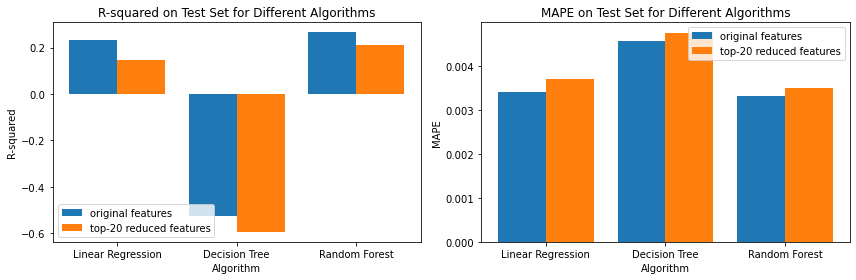

In [54]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.bar(np.arange(3), model_r2, width=0.4, label='original features')
plt.bar(np.arange(3)+0.4, model_reduced_r2, width=0.4, label='top-20 reduced features')
plt.xticks(np.arange(3)+0.2, model_names, rotation=0)
plt.xlabel('Algorithm')
plt.ylabel('R-squared')
plt.title('R-squared on Test Set for Different Algorithms')
plt.legend()

plt.subplot(1,2,2)
plt.bar(np.arange(3), model_mape, width=0.4, label='original features')
plt.bar(np.arange(3)+0.4, model_reduced_mape, width=0.4, label='top-20 reduced features')
plt.xticks(np.arange(3)+0.2, model_names, rotation=0)
plt.xlabel('Algorithm')
plt.ylabel('MAPE')
plt.title('MAPE on Test Set for Different Algorithms')
plt.legend()
plt.tight_layout()

plt.show()

As shown in the figure above, the models trained by all the 90 features outperforms the reduced top-20 features. Random forest has the best performance among the 3 algorithms. Decision tree is the worst without careful hyperparameter tuning, as it is algorithm most likely to be overfitted.

# Error analysis
I took the best performing models (linear regression and random forest) and checked the predicted error vs. actual release year on the test set.

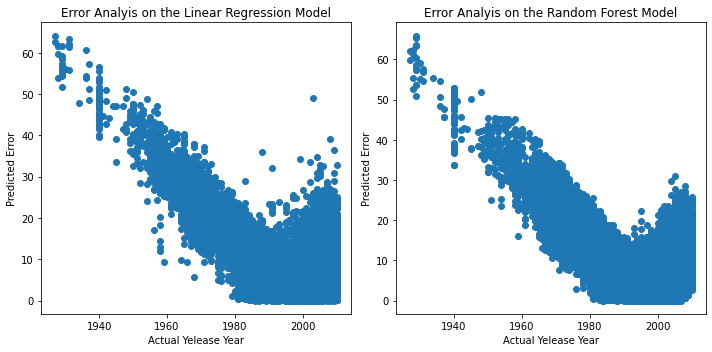

In [62]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(model_dict['Linear Regression'].y_test, np.abs(model_dict['Linear Regression'].y_test-model_dict['Linear Regression'].y_pred))
plt.xlabel('Actual Yelease Year')
plt.ylabel('Predicted Error')
plt.title('Error Analyis on the Linear Regression Model')

plt.subplot(1,2,2)
plt.scatter(model_dict['Random Forest'].y_test, np.abs(model_dict['Random Forest'].y_test-model_dict['Random Forest'].y_pred))
plt.xlabel('Actual Yelease Year')
plt.ylabel('Predicted Error')
plt.title('Error Analyis on the Random Forest Model')
plt.tight_layout()
plt.show()

As shown in the figure above, the random forest model has generally smaller errors than the linear regression model. The RF model has the largest errors on the songs released in th early years, probably due to the lack of data points around years prior to 1960s. The model does the best in 1990s where most of the predictions has error < 15 years.

# Conclusion
1. I used f_regression to selecte the best 20 features with the "SelectKBest" method in sklearn
2. I trained 3 models and received decent performance from random forest and linear regression. However, the decision tree model performs very poorly.
3. Future work involves running hyperparameter tuning to further improve the performance of the models. However, the size of the data is quite large and a single-shot random forest model takes 30 mins, there is no way I can do the hyperparameter tuning on my local machine.